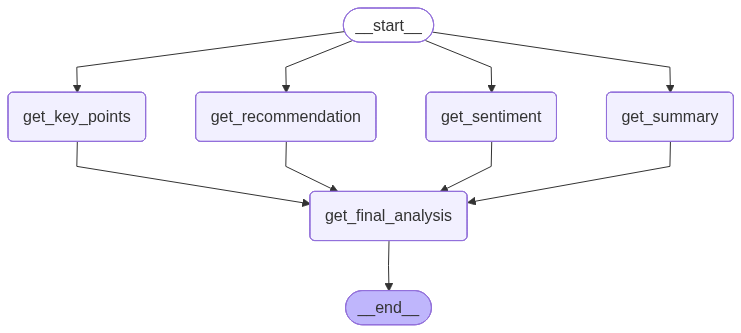

In [ ]:
# paralleization.ipynb
from typing_extensions import TypedDict, Literal
from typing import List
from langgraph.types import Command
from langgraph.graph import StateGraph, START, END
from langchain.chat_models import init_chat_model
from pydantic import BaseModel

llm = init_chat_model("openai:gpt-4o-mini")
class State(TypedDict):

    document: str
    summary: str
    sentiment: str
    key_points: str
    recommendation: str
    final_analysis: str
def get_summary(state: State):
    response = llm.invoke(
        f"Write a 3-sentence summary of this document {state["document"]}"
    )
    return {
        "summary": response.content,
    }


def get_sentiment(state: State):
    response = llm.invoke(
        f"Analyse the sentiment and tone of this document {state["document"]}"
    )
    return {
        "sentiment": response.content,
    }


def get_key_points(state: State):
    response = llm.invoke(
        f"List the 5 most important points of this document {state["document"]}"
    )
    return {
        "key_points": response.content,
    }


def get_recommendation(state: State):
    response = llm.invoke(
        f"Based on the document, list 3 recommended next steps {state["document"]}"
    )
    return {
        "recommendation": response.content,
    }


def get_final_analysis(state: State):
    response = llm.invoke(
        f"""
    Give me an analysis of the following report

    DOCUMENT ANALYSIS REPORT
    ========================

    EXECUTIVE SUMMARY:
    {state['summary']}

    SENTIMENT ANALYSIS:
    {state['sentiment']}

    KEY POINTS:
    {state.get("key_points", "")}

    RECOMMENDATIONS:
    {state.get('recommendation', "N/A")}
    """
    )
    return {
        "final_analysis": response.content,
    }
graph_builder = StateGraph(State)

graph_builder.add_node("get_summary", get_summary)
graph_builder.add_node("get_sentiment", get_sentiment)
graph_builder.add_node("get_key_points", get_key_points)
graph_builder.add_node("get_recommendation", get_recommendation)
graph_builder.add_node("get_final_analysis", get_final_analysis)


graph_builder.add_edge(START, "get_summary")
graph_builder.add_edge(START, "get_sentiment")
graph_builder.add_edge(START, "get_key_points")
graph_builder.add_edge(START, "get_recommendation")

graph_builder.add_edge("get_summary", "get_final_analysis")
graph_builder.add_edge("get_sentiment", "get_final_analysis")
graph_builder.add_edge("get_key_points", "get_final_analysis")
graph_builder.add_edge("get_recommendation", "get_final_analysis")

graph_builder.add_edge("get_final_analysis", END)


graph = graph_builder.compile()

graph

In [3]:
with open("fed_transcript.md", "r", encoding="utf-8") as file:
    document = file.read()

for chunk in graph.stream(
    {"document": document},
    stream_mode="updates",
):
    print(chunk, "\n")

{'get_summary': {'summary': 'In a recent update, the Federal Open Market Committee expressed a commitment to achieving maximum employment and stable prices while addressing recent economic shifts, including a slight uptick in the unemployment rate and rising inflation. The committee decided to lower the federal funds rate by a quarter percentage point and to continue reducing securities holdings in response to the evolving labor market and inflation dynamics. Despite signs of economic moderation and increased downside risks to employment, the committee remains focused on balancing its dual mandate while monitoring the potential impacts of tariffs and other economic policies.'}} 

{'get_recommendation': {'recommendation': "Based on the information provided in the document, here are three recommended next steps that could be taken by the Federal Open Market Committee (FOMC) or policymakers:\n\n1. **Monitor Economic Indicators Closely**: Continue to track key economic indicators such as e